In [6]:
from dptb.nn.build import build_model
from dptb.postprocess.bandstructure.band import Band
import  matplotlib.pyplot  as plt
import numpy as np
from ase.io import read
from dptb.data import AtomicData, AtomicDataDict
import json
import torch

In [7]:
# The settings for the model. must be provided.

run_opt = {
        "init_model": "./spdckpt/nrl_tb_ckpt.json",
        "restart": None,
        "freeze": False,
        "train_soc": False,
        "log_path": None,
        "log_level": None
    }

model_option = {
    "nnsk": {
        "onsite": {"method": "NRL","rc":6.6147151362875, "w": 0.2645886054515,'lda':1.5269575694188455},
        "hopping": {"method": "NRL1", "rc":6.6147151362875, "w": 0.2645886054515},
        "push": False,
        "freeze": False
    }
}
common_options = {
"basis": {
    "Si": ["3s","3p","d*"]
},
"device": "cpu",
"dtype": "float32",
"overlap": True
}

# Build the model
model = build_model(run_opt, model_option, common_options)


The model option std in nnsk is not defined in input model_options, set to 0.01.


In [8]:
#set the band structure task
jdata={   
    "task_options": {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[[0.0000000000,  0.0000000000,   0.0000000000,   50],   
                [0.5000000000,   0.0000000000,   0.5000000000,   50],               
                [0.6250000000,   0.2500000000,   0.6250000000,   1],    
                [0.3750000000,   0.3750000000,   0.7500000000,   50],     
                [0.0000000000,   0.0000000000,   0.0000000000,   50],    
                [0.5000000000,   0.5000000000,   0.5000000000,   50],                
                [0.5000000000,   0.2500000000,   0.7500000000,   50],               
                [0.5000000000,   0.0000000000,   0.5000000000,   1 ]
                ],
        "klabels":["G","X","X/U","K","G","L","W","X"],
        "E_fermi":-9.307,
        "emin":-15,
        "emax":10,
        "ref_band": "./data/kpath.0/eigenvalues.npy"
    }
}

stru_data = "./data/silicon.vasp"
AtomicData_options = {"r_max": 5.0, "oer_max":6.6147151362875, "pbc": True}

In [9]:
#band = np.load("./data/kpath.0/eigs.npy")[0]
# calculate the band structure
kpath_kwargs = jdata["task_options"]
bcal = Band(model=model, 
            use_gui=True, 
            results_path='./', 
            overlap = True,
            device=model.device)



eigenstatus = bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs, 
               AtomicData_options=AtomicData_options)

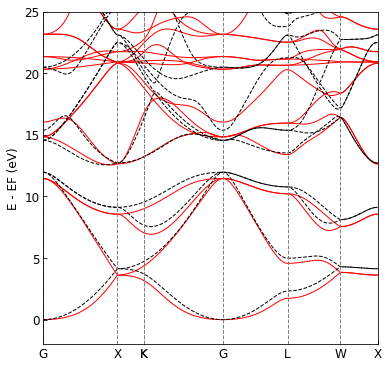

In [10]:
# plot the band structure w.r.t. DFT results
#band = np.load(f'./data/kpath.0/eigenvalues.npy')
band = np.load("./data/kpath.0/eigs.npy")

if len(band.shape)==3:
    band = band[0,:,:]
plt.figure(figsize=(6,6),dpi=72)
plt.plot(eigenstatus['xlist'], eigenstatus['eigenvalues']*13.605662285137- np.min(eigenstatus['eigenvalues'])*13.605662285137, 'r-',lw=1)
plt.plot(eigenstatus['xlist'], band[:,:] - np.min(band[:,:]),'k--',lw=1)
plt.ylim(-2,25)

for ii in eigenstatus['high_sym_kpoints']:
    plt.axvline(ii,color='gray',lw=1,ls='--')
plt.tick_params(direction='in')

plt.xlim(eigenstatus['xlist'].min(),eigenstatus['xlist'].max())

plt.ylabel('E - EF (eV)',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(eigenstatus['high_sym_kpoints'], eigenstatus['labels'], fontsize=12)
#plt.savefig(f'{self.results_path}/band.png',dpi=300)
plt.show()